In [1]:
# Import necessary libraries

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.metrics.regression import MeanAbsoluteRelativeError
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine



import pandas as pd
import numpy as np
import os
from Cross_Stitch_models.cross_stitch_network import CrossStitchNetwork
from utils.dynamic_losses import MultiTaskDynamicLoss
from ignite.metrics import *
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

TRAINING_PATH = 'data'
TESTING_PATH = 'data'
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for Apple Silicon if available
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using device: {device}")

Using device: cpu


In [3]:
dec_train = np.loadtxt(f'{TRAINING_PATH}/Train_Dst_NoAuction_DecPre_CF_7.txt')


dec_test1 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_test.shape)

(149, 254750) (149, 139587)


In [4]:
def __extract_stock__(df, stock_idx, test = False, val = False):
    """
    Extract specific stock data from a DataFrame using stock index.

    Parameters
    ----------
    df: Pandas DataFrame
        Input DataFrame containing raw stock data.
    stock_idx: {0, 1, 2, 3, 4}
        Index of the stock to extract.

    Returns
    -------
    Pandas DataFrame
        Extracted stock data.
    """
    if test :
        n_boundaries = 14
    else :
        n_boundaries = 4

    # Calculate boundaries based on changes in the midprice column
    boundaries = np.sort(
        np.argsort(np.abs(np.diff(df['midprice'], prepend=np.inf)))[-n_boundaries - 1:]
    )

    # Append the last index as the upper boundary
    boundaries = np.append(boundaries, [len(df)])

    # Split the data into segments based on the calculated boundaries
    split_data = [df.iloc[boundaries[i] : boundaries[i + 1]] for i in range(n_boundaries + 1)]

    # Return the segment corresponding to the stock_idx
    return split_data[stock_idx]

def extract_all_stocks(df, test = False):
    """
    Extract all stocks from a DataFrame and assign stock identifiers.

    Parameters
    ----------
    df: Pandas DataFrame
        Input DataFrame containing raw stock data.

    Returns
    -------
    Pandas DataFrame
        A combined DataFrame of all extracted stocks with a 'STOCK' column.
    """
    stocks = []
    if test : 
        #Since test is made of 3 days, there are three days of data, so 5 stocks per day
        length = 15
    else : 
        length = 5
    for stock_idx in range(length):
        stock_data = __extract_stock__(df, stock_idx, test)
        
        # Assign stock identifier wheter it is testing or training
        if test : 
            stock_data['STOCK'] = stock_idx%5
            stock_data['DAY'] = 7 + stock_idx//5
        else : 
            stock_data['STOCK'] = stock_idx
        stocks.append(stock_data)
    return pd.concat(stocks, ignore_index=True)


In [5]:
def to_dataframe(array) -> pd.DataFrame:
    data = {}

    for level in range(10):
        data[f"PRICE_ASK_{level}"] = array[4 * level]
    for level in range(10):
        data[f"PRICE_BID_{level}"] = array[4 * level + 2]
    for level in range(10):
        data[f"VOLUME_ASK_{level}"] = array[4 * level + 1]
    for level in range(10):
        data[f"VOLUME_BID_{level}"] = array[4 * level + 3]
    data['midprice'] = data['PRICE_ASK_0'] + data['PRICE_BID_0']

    return pd.DataFrame(data)

In [6]:
df_train = to_dataframe(dec_train)
df_test = to_dataframe(dec_test)


In [7]:
df_train = extract_all_stocks(df_train)
df_test =extract_all_stocks(df_test, test=True)


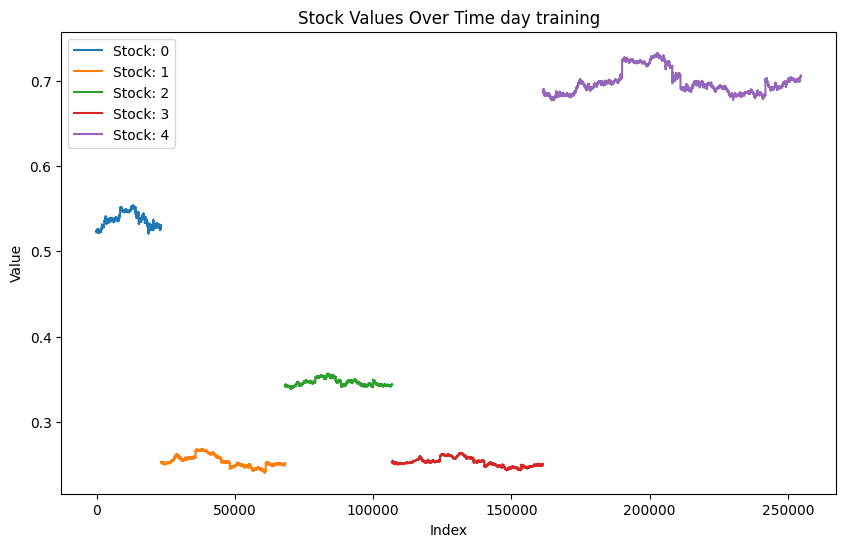

In [8]:
import matplotlib.pyplot as plt


stocks = df_train.groupby('STOCK')

# Create a plot for each stock
plt.figure(figsize=(10, 6))
for stock, group in stocks:
    plt.plot(group['midprice'], label=f"Stock: {stock}")

plt.title("Stock Values Over Time day training")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

def horizon_volatility_log_return(mid_prices, horizon):
    """
    Calculate rolling volatility based on log returns over a given horizon.

    Parameters:
    -----------
    mid_prices : numpy.ndarray
        Array of mid-prices.
    horizon : int
        Horizon over which to calculate log return volatility.

    Returns:
    --------
    numpy.ndarray
        Rolling volatility based on log returns.
    """
    log_returns = np.log(mid_prices[1:] / mid_prices[:-1])
    volatility = np.sqrt(np.convolve(log_returns ** 2, np.ones(horizon), mode='valid') / horizon)


    scale_volatility = (volatility)*1000

    return scale_volatility

def data_time_length(X, Y, T):
    """
    Prepare time-series data for a given time length.

    Parameters:
    -----------
    X : numpy.ndarray
        Input features.
    Y : numpy.ndarray
        Target variables.
    T : int
        Time length for sequences.

    Returns:
    --------
    tuple
        Tuple containing:
        - dataX: Prepared input features (time-series format).
        - dataY: Corresponding target variables.
    """
    N, D = X.shape
    dataY = np.array(Y[T - 1:N])
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = X[i - T:i, :]
    return dataX, dataY

# Custom PyTorch Dataset class
class VolatilityDataset(Dataset):
    """
    Custom Dataset class for volatility forecasting.
    """
    def __init__(self, data, horizons, T, mean=None, std=None, compute_stats=False):
        """
        Initialization of the dataset.

        Parameters:
        -----------
        data : pandas.DataFrame
            Input DataFrame with features and target variables.
        horizons : list
            List of horizons for which to compute features.
        T : int
            Time length for sequences.
        mean : np.ndarray
            Precomputed mean values for normalization.
        std : np.ndarray
            Precomputed standard deviation values for normalization.
        compute_stats : bool
            Whether to compute mean and std from the dataset.
        """
        self.horizons = horizons
        self.T = T

        # Extract features (excluding mid_price and STOCK)
        self.features = data.loc[:, data.columns.str.contains('PRICE|VOLUME')].values

        # Extract mid-prices for calculating volatility
        mid_prices = data['midprice'].values

        # Compute rolling volatility
        rolling_volatility = []
        min_length = len(mid_prices) - max(horizons)  # Use the smallest valid length
        for horizon in horizons:
            rv = horizon_volatility_log_return(mid_prices, horizon)
            rolling_volatility.append(rv[:min_length])  # Truncate to minimum valid length

        rolling_volatility = np.array(rolling_volatility).T  # Shape: [min_length, len(horizons)]

        # Align features with valid rolling volatility length
        self.features = self.features[:min_length]
        valid_indices = ~np.isnan(rolling_volatility).any(axis=1)

        # Apply valid indices
        self.features = self.features[valid_indices]
        rolling_volatility = rolling_volatility[valid_indices, :]

        self.y = rolling_volatility

        # Normalize features
        if compute_stats:
            self.mean = self.features.mean(axis=0)
            self.std = self.features.std(axis=0)
        else:
            self.mean = mean
            self.std = std

        # Apply normalization
        self.features = (self.features - self.mean) / (self.std + 1e-8)

        # Convert to time-series format
        self.features, self.y = data_time_length(self.features, self.y, self.T)
        self.features = self.features[:, None, :, :]  # Add channel dimension for PyTorch

    def __len__(self):
        """Returns the total number of samples."""
        return self.features.shape[0]

    def __getitem__(self, index):
        """Generates one sample of data."""
        return torch.tensor(self.features[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

# Parameters
batch_size = 32
horizons = [20, 50, 100]
T = 100

unique_stocks = df_train['STOCK'].unique()

# Dictionary to store DataLoaders for each stock
dataloaders = {}

for stock in unique_stocks:
    print(f"Processing Stock: {stock}")

    # Filter data for the current stock
    stock_data_train = df_train[df_train['STOCK'] == stock]
    stock_data_test = df_test[df_test['STOCK'] == stock]

    # Compute mean and std from the training set
    train_dataset = VolatilityDataset(stock_data_train, horizons=horizons, T=T, compute_stats=True)
    train_mean, train_std = train_dataset.mean, train_dataset.std
    # Use the same normalization statistics for the test set
    test_dataset = VolatilityDataset(stock_data_test, horizons=horizons, T=T, mean=train_mean, std=train_std)

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Store DataLoaders in the dictionary
    dataloaders[stock] = {
        'train_loader': train_loader,
        'test_loader': test_loader
    }

    print(f"Stock {stock} - Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")

print("Data preparation complete for all stocks.")



Processing Stock: 0
Stock 0 - Train Size: 23137, Test Size: 6209
Processing Stock: 1
Stock 1 - Train Size: 44675, Test Size: 22862
Processing Stock: 2
Stock 2 - Train Size: 38350, Test Size: 24150
Processing Stock: 3
Stock 3 - Train Size: 54476, Test Size: 31731
Processing Stock: 4
Stock 4 - Train Size: 93117, Test Size: 53640
Data preparation complete for all stocks.


In [10]:
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine, EarlyStopping
from torch.utils.tensorboard import SummaryWriter
import gc
from ignite.contrib.handlers import ProgressBar
import time

def create_supervised_trainer(index_testing) :
  # Clear unused GPU memory
  torch.cuda.empty_cache()  
  gc.collect()  

  # Initialize TensorBoard writer
  writer = SummaryWriter(log_dir="../t3-dl-lob/data/runs/cross_stitch_network")

  #initialize experimentation settings
  torch.set_default_dtype(torch.float32)
  torch.cuda.manual_seed(42)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


  # Initialize model and move to the correct device
  number_of_tasks = len(horizons)
  time_span = torch.linspace(0, 1, 100, dtype=torch.float32).to(device)
  model = CrossStitchNetwork(number_of_tasks=number_of_tasks, time_span=time_span)
  model.to(device)

  # Loss function and optimizer
  is_regression = torch.Tensor([True, True, True]).to(device)
  criterion = MultiTaskDynamicLoss(is_regression=is_regression, reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

  # Training function
  def update_function(engine, batch):
    start_time = time.time()
    input1, targets = batch

    # Move data to GPU with non_blocking transfers
    input1 = input1.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True)

    # Clone inputs for multi-task processing
    inputs = [input1.clone() for _ in range(number_of_tasks)]

    model.train()
    optimizer.zero_grad()


    predictions = model(*inputs)
    # Compute individual task losses
    losses = [torch.mean(torch.abs(pred- targets[:, i])) for i, pred in enumerate(predictions)]

    # Aggregate losses
    loss = criterion(torch.stack(losses))

    # Backward pass
    loss.backward()
    optimizer.step()

    end_time = time.time()

    return loss.item()

  # Inference function
  def inference(engine, batch):
    input1, targets = batch

    # Move data to GPU with non_blocking transfers (if pinned memory is supported)
    input1 = input1.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True)

    # Clone inputs for multi-task processing
    inputs = [input1.clone() for _ in range(number_of_tasks)]

    model.eval()
    with torch.no_grad():
        predictions = model(*inputs)

    return {f'out{i+1}': (pred, targets[:, i]) for i, pred in enumerate(predictions)}

  # Create training and validation engines
  trainer = Engine(update_function)
  validator = Engine(inference)

  # Create time-stamp for the current run
  pbar = ProgressBar()
  pbar.attach(trainer)
  pbar = ProgressBar()
  pbar.attach(validator)

  # Define the checkpoint handler
  checkpointer = Checkpoint(
    to_save={'model': model, 'optimizer': optimizer},  
    save_handler=DiskSaver(dirname='"/content/gdrive/MyDrive/t3-dl-lob/data/checkpoints', create_dir=True, require_empty=False),  
    n_saved=2  # Keep the last 2 checkpoints
  )

  # Attach the checkpoint handler to the trainer
  trainer.add_event_handler(Events.EPOCH_COMPLETED(every=1), checkpointer)

  # Attach metrics to the validator
  def output_transform_horizon(index):
    def transform(output):
        y_pred, y_true = output[f'out{index + 1}']
        scale = 1000
        y_pred_scaled_back = (y_pred)/scale
        y_true_scaled_back = (y_true)/scale
        mask = y_true_scaled_back != 0
        if y_pred_scaled_back.dim() > 1 and y_pred_scaled_back.shape[1] == 1:  # Check if squeezing is needed
            y_pred_scaled_back = y_pred_scaled_back.squeeze(1)
        return y_pred_scaled_back[mask], y_true_scaled_back[mask]
    return transform

  # Attach metrics to the validator
  for i, horizon in enumerate(horizons):
    MeanAbsoluteRelativeError(output_transform=output_transform_horizon(i)).attach(
        validator, f'Mean Absolute Relative Error Horizon {horizon}'
    )

  # Attach the loss metric
  @trainer.on(Events.EPOCH_COMPLETED)
  def validate(engine):
    validator.run(dataloaders[index_testing]['test_loader'])
    metrics = validator.state.metrics
    for metric_name, value in metrics.items():
        writer.add_scalar(metric_name, value, engine.state.epoch)
        print(f"{metric_name}: {value:.4f}")

  # Log training loss to TensorBoard
  @trainer.on(Events.ITERATION_COMPLETED(every=1))
  def log_training(engine):
    iteration = engine.state.iteration
    loss = engine.state.output
    if iteration % 10 == 0:
        writer.add_scalar("Loss/train", loss, iteration)  

  # Close TensorBoard writer
  @trainer.on(Events.COMPLETED)
  def close_writer(engine):
    writer.close()
    print("TensorBoard writer closed.")

  return trainer

2024-12-19 11:04:44.487310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#For each stock, train the model
for i in range(5) :
  print(f'Training for stock {i + 1}')
  trainer = create_supervised_trainer(i)
  trainer.run(dataloaders[i]['train_loader'], max_epochs=5)
  print(f"Training completed for stock {i + 1}. Check TensorBoard for metrics and profiling.")


Training for stock 1


Engine run is terminating due to exception: 


KeyboardInterrupt: 

Training and testing of the TFT transformer

In [12]:
def to_dataframe(array) -> pd.DataFrame:
    data = {}
    for level in range(10):
        data[f"PRICE_ASK_{level}"] = array[4 * level]
    for level in range(10):
        data[f"PRICE_BID_{level}"] = array[4 * level + 2]
    for level in range(10):
        data[f"VOLUME_ASK_{level}"] = array[4 * level + 1]
    for level in range(10):
        data[f"VOLUME_BID_{level}"] = array[4 * level + 3]
    data['midprice'] = data['PRICE_ASK_0'] + data['PRICE_BID_0']
    data['SPREAD'] = data['PRICE_ASK_0'] - data['PRICE_BID_0']

    return pd.DataFrame(data)

In [13]:
df_train = to_dataframe(dec_train)
df_test = to_dataframe(dec_test)
df_train = extract_all_stocks(df_train)
df_test =extract_all_stocks(df_test, test=True)


In [14]:
def process_stock_group(group):
    # Calculate log mid price
    group['log_midprice'] = np.log(group['midprice'])
    
    # Calculate log return
    group['log_return'] = group['log_midprice'].diff()
    
    # Calculate rolling volatility for different windows
    for k in [20, 50, 100]:
        group[f'rolling_volatility_{k}'] = group['log_return'].rolling(window=k).std()
    
    return group

# Apply the function to each group
train_dataframe = df_train.groupby('STOCK').apply(process_stock_group)
test_dataframe = df_test.groupby('STOCK').apply(process_stock_group)

train_dataframe.reset_index(drop=True, inplace=True)
test_dataframe.reset_index(drop=True, inplace=True)

In [15]:
train_dataframe['DAY'] = -1

train_dataframe.dropna(inplace=True, subset=['log_return', 'rolling_volatility_20', 'rolling_volatility_50', 'rolling_volatility_100'])
test_dataframe.dropna(inplace=True, subset=['log_return', 'rolling_volatility_20', 'rolling_volatility_50', 'rolling_volatility_100'])

df = pd.concat([train_dataframe, test_dataframe])
df['id'] = 0
df['time'] = df.groupby('DAY').cumcount()
df['dummy_col'] = 0

In [16]:
from Temporal_Fusion_Transform.data_formatters.volatility import VolatilityFormatter
from Temporal_Fusion_Transform.data_formatters import ts_dataset  
from Temporal_Fusion_Transform import tft_model


#Define the transformer
def initialize_Transformer(horizon) : 
    data_formatter = VolatilityFormatter()
    df.rename(columns={f'rolling_volatility_{horizon}': 'rolling_volatility'}, inplace=True)
    train, valid, test = data_formatter.split_data(df)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
    )

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params(horizon)
    params = data_formatter.get_default_model_params()
    #Set the parameters for the fusiontime transformer
    id_col = 'id'
    time_col='time'

    input_cols = ['STOCK', 'dummy_col', 'PRICE_ASK_0','PRICE_BID_0','VOLUME_ASK_0', 'VOLUME_BID_0','SPREAD','midprice']

    static_col = 'STOCK'
    target_col = 'rolling_volatility'
    time_steps=192
    num_encoder_steps = 168
    output_size = 1
    max_samples = 258000
    num_statics = 1
    input_size = 8

    vol = ts_dataset.TSDataset(id_col, static_col,time_col, input_cols,target_col, time_steps, max_samples,input_size, num_encoder_steps, num_statics,output_size, train)

    batch_size=64
    loader = DataLoader(
                vol,
                batch_size=batch_size,
                num_workers=2,
                shuffle=True
            )
    for batch in loader :
        break
    static_cols = ['STOCK']
    categorical_cols = ['dummy_col']
    real_cols = ['PRICE_ASK_0','PRICE_BID_0','VOLUME_ASK_0', 'VOLUME_BID_0','SPREAD','midprice']

    config = {}
    config['static_variables'] = 1
    config['time_varying_categoical_variables'] = 1
    config['time_varying_real_variables_encoder'] = 4
    config['time_varying_real_variables_decoder'] = 3
    config['num_masked_series'] = 1
    config['seq_length'] = vol.time_steps
    config['static_embedding_vocab_sizes'] = [369]
    config['time_varying_embedding_vocab_sizes'] = [369]
    config['embedding_dim'] = 8
    config['lstm_hidden_dimension'] = 160
    config['lstm_layers'] = 15
    config['dropout'] = 0.05
    config['device'] = 'cpu'
    config['batch_size'] = 64
    config['encode_length'] = 168
    config['attn_heads'] = 4
    config['num_quantiles'] = 3
    config['vailid_quantiles'] = [0.1,0.5,0.9]
    model = tft_model.TFT(config)
    output,encoder_output, decoder_output, \
    attn,attn_output_weights, \
    static_embedding, embeddings_encoder = model.forward(batch)
    df.rename(columns={'rolling_volatility': f'rolling_volatility_{horizon}'}, inplace=True)
    return model, loader

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

#Run the fusiontime transformer
def run_model(model, loader) : 
    q_loss_func = tft_model.QuantileLoss([0.1, 0.5, 0.9])

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    epochs=10
    losses = []
    for i in range(epochs):
        epoch_loss = [] 
        j=0
        for batch in loader:
            output = model(batch)
            
            inputs = batch['inputs']
            outputs = batch['outputs']
            predictions, *other_outputs = output

            loss = q_loss_func(predictions[:,:,:].view(-1,3), outputs[:,:,0].flatten().float())
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            j+=1
            if j>5:
                break
        losses.append(np.mean(epoch_loss))
        print(np.mean(epoch_loss))
    # Randomly choose an index
    ind = np.random.choice(64)
    print(f"Selected index: {ind}")

    # Extract predictions and true values
    pred_1 = predictions[ind, :, 0].detach().cpu().numpy()
    pred_5 = predictions[ind, :, 1].detach().cpu().numpy()
    pred_9 = predictions[ind, :, 2].detach().cpu().numpy()
    true_values = batch['outputs'][ind, :, 0].detach().cpu().numpy()

    # Calculate MARE
    def mean_absolute_relative_error(pred, true):
        mask = true != 0  # Avoid division by zero
        return np.mean(np.abs((pred[mask] - true[mask]) / true[mask]))

    mare_1 = mean_absolute_relative_error(pred_1, true_values)
    mare_5 = mean_absolute_relative_error(pred_5, true_values)
    mare_9 = mean_absolute_relative_error(pred_9, true_values)

    print(f"MARE (Quantile 1): {mare_1:.4f}")
    print(f"MARE (Quantile 5): {mare_5:.4f}")
    print(f"MARE (Quantile 9): {mare_9:.4f}")

    # Plot predictions and true values
    plt.plot(pred_1, label=f'pred_1 (MARE={mare_1:.4f})')
    plt.plot(pred_5, label=f'pred_5 (MARE={mare_5:.4f})')
    plt.plot(pred_9, label=f'pred_9 (MARE={mare_9:.4f})')
    plt.plot(true_values, label='true', linestyle='--')

    plt.legend()
    plt.title("Predictions vs True Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.show()
    mae_50_all = []

    # Updated mean_absolute_relative_error function
    def mean_absolute_relative_error(pred, true):
        mask = true != 0  # Avoid division by zero
        if not mask.any():  # Handle cases where true is all zeros
            return np.nan
        return np.mean(np.abs((pred[mask] - true[mask]) / true[mask]))

    # Loop through all samples
    for i in range(predictions.shape[0]):
        pred_5_all = predictions[i, :, 1].detach().cpu().numpy()
        true_values_all = batch['outputs'][i, :, 0].detach().cpu().numpy()
        mae_50_all.append(mean_absolute_relative_error(pred_5_all, true_values_all))

    # Calculate the mean MAE while ignoring NaN values
    mean_mae_50 = np.nanmean(mae_50_all)
    print(f"Mean MAE for the 50th quantile over all samples: {mean_mae_50:.4f}")


In [18]:
#Run the model for different horizons
for horizon in [20, 50, 100] :
    model, loader = initialize_Transformer(horizon)
    print(f'Training for horizon {horizon}')
    run_model(model, loader)

Formatting train-valid-test splits.
Setting scalers with training data...
Getting valid sampling locations.
Max samples=258000 exceeds # available segments=254059


KeyboardInterrupt: 